# program to see the effect of different kinds of noise in QAOA performance with increasing layers (depth)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    thermal_relaxation_error  # for T1 + T2 error combined
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


Problem Maxcut graph

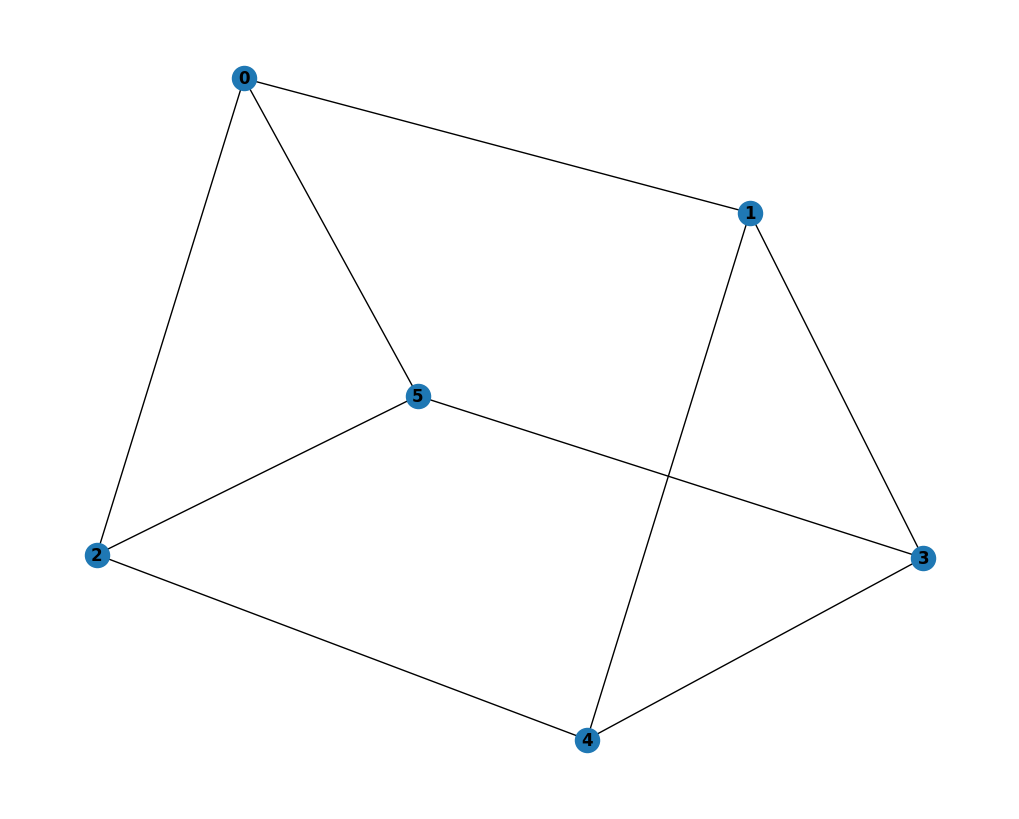

In [56]:
# make sure dxn is even for d-regular graph.
n = 6  # number of vertices
d = 3  #  d-regular graph
p = 5  # QAOA layers

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G = nx.random_regular_graph(d ,n)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')

# weight matrix
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)
plt.savefig('cost_function_landspace.pdf', dpi=300, bbox_inches='tight')
plt.close
plt.show()


Classical Maxcut solution which is the exact value of Maxcut, Calculated using the Brute force method.
This method gives the actual Maxcut value $C_{max}$ but it takes exponential time to reach the solution.

In [57]:
# classical solution
sol1 = 0
for b in range(2**n):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value1 = 0
    for i in range(n):
        for j in range(n):
            Cut_value1 += w[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 7.0


Converting our Maxcut problem into cost hamiltonian, $H_C$ which is used to solve it using quantum algorithm. Because in quantum mechanics, we deal with the operators, not classical functions. So we need to convert our classical cost function $C_X$ into Cost hamiltonian $H_C$.
# Note:
There is a term called $offset$ which we geet, when converting the $C_X$ into $H_C$. This $offset$, shifts the actual energy landscape with this $offset$ value. So after calculating the energy using QAOA, $<H_C>$, we have to add this $offset$ value to it to get the actual ground state energy.

In [58]:
prob=Maxcut(w)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian, offset = qubo.to_ising()
print(offset)
print(cost_hamiltonian)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_5 - 2*x_1*x_3 - 2*x_1*x_4 - 2*x_2*x_4
  - 2*x_2*x_5 - 2*x_3*x_4 - 2*x_3*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_0*x_5 + 2*x_1*x_3 + 2*x_1*x_4 + 2*x_2*x_4
  + 2*x_2*x_5 + 2*x_3*x_4 + 2*x_3*x_5 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

-4.5
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'ZIIIIZ', 'IIZIZI', 'IZIIZI', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


The following function calculates the expectation value of operator, $\hat{H_C}$ w.r.t the state prepared using the parameterized quantum circuit, ansatz. This is done using EstimatorV2, which estimates the expectation value.

In [59]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

# Errors in a actual IBM quantum device, IBMQX4

In [60]:
# Coherence times (in nanoseconds)
T1_fixed = 45e3  # relaxation time (amplitude damping error)
T2_fixed = 20e3  # dephasing time (phase damping error)

# Time taken by different gates
u1 = 0.0  # RZ(gamma) gate (Virtual gate) 
u2 = 60  # Hadamard Gate
u3 = 120  # RX(beta) gate
cx = 720  # CNOT gate (2-qubit gate)

# gate error probability (Depolarizing Error)
err_1q_fixed = 1.5e-3  # 1-qubit gate error
err_2q_fixed = 4e-2  # 2-qubit gate error

Taking a range for all these errors to see the behavior of QAOA

In [61]:
T1 = np.linspace(6*T1_fixed, 0.5*T1_fixed, 7)
T2 = np.linspace(8*T2_fixed, 0.5*T2_fixed, 7)

err_1q = np.linspace(0.25*err_1q_fixed, 1*err_1q_fixed, 7)
err_2q = np.linspace(0.25*err_2q_fixed, 1*err_2q_fixed, 7)

defining 2D zeros arrays to store the cost w.r.t. different kinds of errors

In [62]:
err_fom_T1 = np.zeros([p, len(T1)])
err_fom_T2 = np.zeros([p, len(T1)])
err_fom_1q = np.zeros([p, len(T1)])
err_fom_2q = np.zeros([p, len(T1)])
err_fom_all = np.zeros([p, len(T1)])
err_fom_ideal = np.zeros([p, len(T1)])


Differnt Noise models

In [63]:
for jj in range(1, p+1, 1):
    # Initializing the parameters for our quanutum circuit 
    # using Trotterized Quantum Annealing Initialization method.
    init_params = np.zeros(2*jj)
    t = 0.75
    for i in range(0, jj, 1):
        init_params[i] = (1.0-i/jj)*t
        init_params[i+jj] = (i/jj)*t

    # Preparing circuit
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=jj)
    circuit.measure_all()

    # Calculating Total time taken by the circuit
    # this time will be used to  cculate the probabilities for T1 and T2 errors
    total_execution_time = (jj*(len(edges)*cx*2+ n*u3)+n*u2)                    
    t = total_execution_time

    for kk in range(0, len(T1), 1):
        #----------------------------------------------------------------------
        # T1 error
        p_t1 = 1 - np.exp(-t / T1[kk])
        error_t1 = amplitude_damping_error(p_t1)  # 1-qubit T1 error
        error_t1_cx = amplitude_damping_error(p_t1).tensor(amplitude_damping_error(p_t1))  # 2-qubit T1 error

        noise_T1 = NoiseModel()
        noise_T1.add_all_qubit_quantum_error(error_t1, ['u1', 'u2', 'u3'])
        noise_T1.add_all_qubit_quantum_error(error_t1_cx, ['cx'])

        sim_T1 = AerSimulator(method='automatic', noise_model=noise_T1)
        pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_T1)
        candidate_circuit1 = pm1.run(circuit)

        with Session(backend=sim_T1) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result1 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit1, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        
        T1_cost = result1.fun+offset
        err_fom_T1[jj-1][kk] = 1.0+T1_cost/sol1


        #---------------------------------------------------------------------------------
        # T2 error
        p_t2 = 1 - np.exp(-t / T2[kk])
        error_t2 = phase_damping_error(p_t2)
        error_t2_cx = phase_damping_error(p_t2).tensor(phase_damping_error(p_t2))

        noise_T2  = NoiseModel()
        noise_T2.add_all_qubit_quantum_error(error_t2, ['u1', 'u2', 'u3'])
        noise_T2.add_all_qubit_quantum_error(error_t2_cx, ['cx'])

        sim_T2 = AerSimulator(method='automatic', noise_model=noise_T2)
        pm2 = generate_preset_pass_manager(optimization_level=3,backend=sim_T2)
        candidate_circuit2 = pm2.run(circuit)

        with Session(backend=sim_T2) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result2 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit2, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        T2_cost = result2.fun+offset
        err_fom_T2[jj-1][kk] = 1.0+T2_cost/sol1


        #-------------------------------------------------------------------------------
        # 1-qubit gate error
        error_1q = depolarizing_error(err_1q[kk], num_qubits=1)  # 1-qubit gate error

        noise_gate_1q = NoiseModel()
        noise_gate_1q.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3'])

        sim_gate_1q = AerSimulator(method='automatic', noise_model = noise_gate_1q)
        pm3_1q = generate_preset_pass_manager(optimization_level=3,backend=sim_gate_1q)
        candidate_circuit3_1q = pm3_1q.run(circuit)

        with Session(backend=sim_gate_1q) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result3 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit3_1q, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        gate_cost = result3.fun+offset
        err_fom_1q[jj-1][kk] = 1.0+gate_cost/sol1

        #-------------------------------------------------------------------------------
        # 2-qubit gate error
        error_2q = depolarizing_error(err_2q[kk], num_qubits=2)  # 1-qubit gate error

        noise_gate_2q = NoiseModel()
        noise_gate_2q.add_all_qubit_quantum_error(error_2q, ['cx'])

        sim_gate_2q = AerSimulator(method='automatic', noise_model = noise_gate_2q)
        pm3_2q = generate_preset_pass_manager(optimization_level=3,backend=sim_gate_2q)
        candidate_circuit3_2q = pm3_2q.run(circuit)

        with Session(backend=sim_gate_2q) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result3 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit3_2q, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        gate_cost = result3.fun+offset
        err_fom_2q[jj-1][kk] = 1.0+gate_cost/sol1

        #-------------------------------------------------------------------------
        # all errors combine
        error_1q_all = error_t1.compose(error_t2).compose(error_1q)
        error_2q_all = error_t1_cx.compose(error_t2_cx).compose(error_2q)

        noise_all = NoiseModel()
        noise_all.add_all_qubit_quantum_error(error_1q_all, ['u1', 'u2', 'u3'])
        noise_all.add_all_qubit_quantum_error(error_2q_all, ['cx'])

        sim_all = AerSimulator(method='automatic', noise_model = noise_all)
        pm4 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
        candidate_circuit4 = pm4.run(circuit)

        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result4 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit4, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        all_cost = result4.fun+offset
        err_fom_all[jj-1][kk] = 1.0+all_cost/sol1


        #--------------------------------------------------------------------------------
        # Ideal Case
        sim_ideal = AerSimulator(method='automatic')
        pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
        candidate_circuit5 = pm5.run(circuit)

        with Session(backend=sim_ideal) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result5 = minimize(
                cost_func_estimator,
                init_params,
                args=(candidate_circuit5, cost_hamiltonian, estimator),
                method="COBYLA",
                tol=1e-3,
            )
        ideal_cost = result5.fun+offset
        err_fom_ideal[jj-1][kk] = 1.0+ideal_cost/sol1


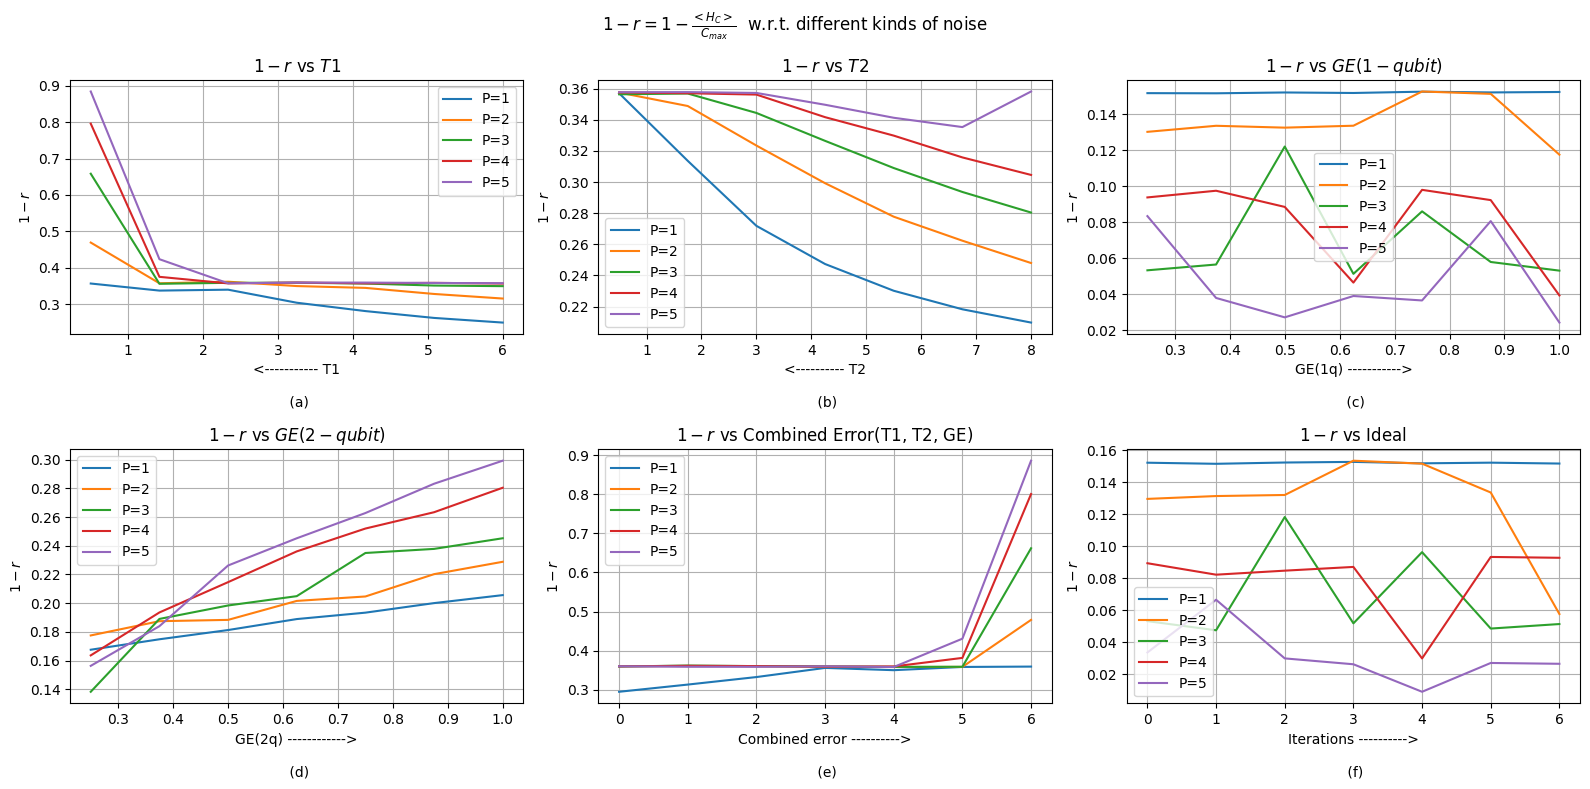

In [64]:
plt.figure(figsize=(16,8))
plt.suptitle('$1-r = 1-\\frac{<H_C>}{C_{max}}$  w.r.t. different kinds of noise')
plt.subplot(2,3,1)
for i in range(0, p, 1):
    plt.plot(T1/T1_fixed, err_fom_T1[i], label=f'P={i+1}')
plt.xlabel('<----------- T1\n \n (a)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $T1$')
plt.tight_layout()
#plt.xticks([])
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(2,3,2)
for i in range(0, p, 1):
    plt.plot(T2/T2_fixed, err_fom_T2[i], label=f'P={i+1}')
plt.xlabel('<---------- T2\n \n (b)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $T2$')
#plt.xticks([])
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(2,3,3)
for i in range(0, p, 1):
    plt.plot(err_1q/err_1q_fixed, err_fom_1q[i], label=f'P={i+1}')
plt.xlabel('GE(1q) ----------->\n \n (c)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $GE(1-qubit)$')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(2,3,4)
for i in range(0, p, 1):
    plt.plot(err_2q/err_2q_fixed, err_fom_2q[i], label=f'P={i+1}')
plt.xlabel('GE(2q) ------------>\n \n (d)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs $GE(2-qubit)$')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(2,3,5)
for i in range(0, p, 1):
    plt.plot(err_fom_all[i], label=f'P={i+1}')
plt.xlabel('Combined error ---------->\n \n (e)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs Combined Error(T1, T2, GE)')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')

plt.subplot(2,3,6)
for i in range(0, p, 1):
    plt.plot(err_fom_ideal[i], label=f'P={i+1}')
plt.xlabel('Iterations ---------->\n \n (f)')
plt.ylabel('$1-r$')
plt.grid()
plt.title('$1-r$ vs Ideal')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.legend(loc='best')
plt.savefig('1_r_vs_various_noise.pdf', dpi=300, bbox_inches='tight')
plt.show()

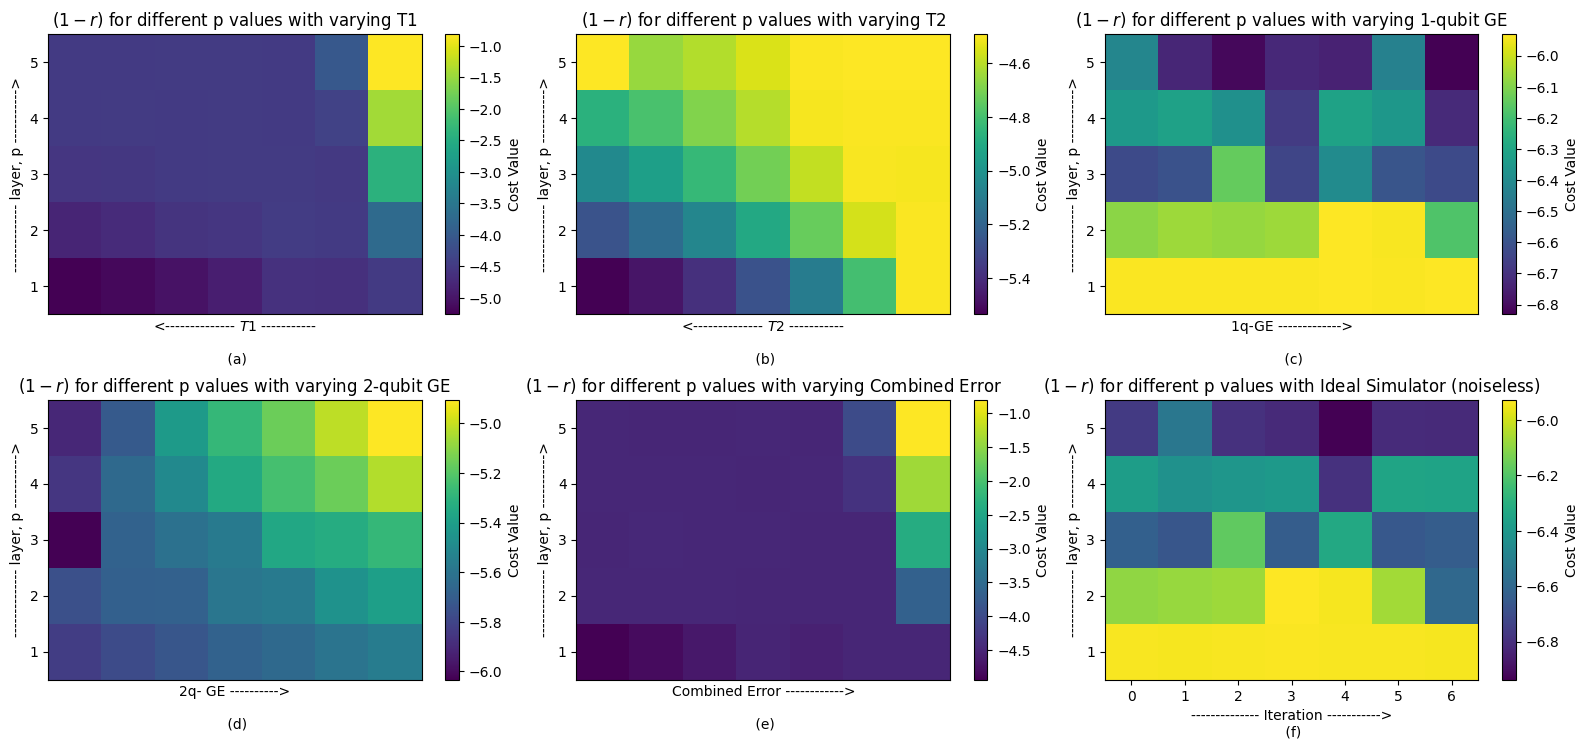

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 1)
plt.tight_layout()
plt.imshow((err_fom_T1-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('<-------------- $T1$ -----------\n \n (a)')
plt.ylabel('-------------- layer, p ----------->')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.xticks([])
plt.title('$(1-r)$ for different p values with varying T1')

plt.subplot(2, 3, 2)
plt.tight_layout()
plt.imshow((err_fom_T2-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('<-------------- $T2$ -----------\n \n (b)')
plt.ylabel('-------------- layer, p ----------->')
plt.title('$(1-r)$ for different p values with varying T2')
#plt.suptitle('$(1-r)$ for different p values with varying T1 and T2 values')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.90)


plt.subplot(2, 3, 3)
plt.tight_layout()
plt.imshow((err_fom_1q-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('1q-GE ------------->\n \n (c)')
plt.ylabel('-------------- layer, p ----------->')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.xticks([])
plt.title('$(1-r)$ for different p values with varying 1-qubit GE')

plt.subplot(2, 3, 4)
plt.tight_layout()
plt.imshow((err_fom_2q-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('2q- GE ---------->\n \n (d)')
plt.ylabel('-------------- layer, p ----------->')
plt.title('$(1-r)$ for different p values with varying 2-qubit GE')
#plt.suptitle('$(1-r)$ for different p values with varying GE values')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.90)


plt.subplot(2, 3, 5)
plt.tight_layout()
plt.imshow((err_fom_all-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('Combined Error ------------>\n \n (e)')
plt.ylabel('-------------- layer, p ----------->')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.xticks([])
plt.title('$(1-r)$ for different p values with varying Combined Error')

plt.subplot(2, 3, 6)
plt.tight_layout()
plt.imshow((err_fom_ideal-1)*sol1, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('-------------- Iteration ----------->\n (f)')
plt.ylabel('-------------- layer, p ----------->')
plt.title('$(1-r)$ for different p values with Ideal Simulator (noiseless)')
#plt.suptitle('$(1-r)$ for different p values with no error, Ideal')
plt.yticks([0.0, 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
#plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('1_r_vs_diff_noise_chart.pdf', dpi=300, bbox_inches='tight')
plt.show()



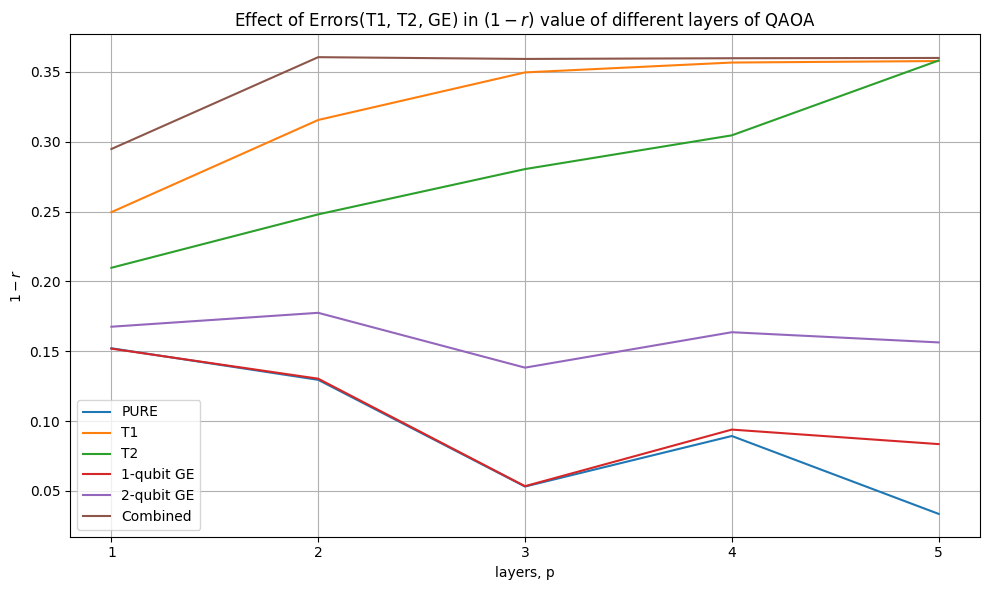

In [66]:
plt.figure(figsize=(10,6))
plt.plot(err_fom_ideal.T[0], label='PURE')
plt.plot(err_fom_T1.T[0], label='T1')
plt.plot(err_fom_T2.T[0], label='T2')
plt.plot(err_fom_1q.T[0], label='1-qubit GE')
plt.plot(err_fom_2q.T[0], label='2-qubit GE')
plt.plot(err_fom_all.T[0], label='Combined')
plt.xlabel('layers, p')
plt.ylabel('$1-r$')
plt.grid()
plt.title('Effect of Errors(T1, T2, GE) in $(1-r)$ value of different layers of QAOA')
plt.tight_layout()
#plt.ylim(0,0.5)
plt.xticks([0., 1., 2., 3., 4.], ['1', '2', '3', '4', '5'])
plt.legend(loc='best')
plt.show()